In [1]:
from models.model_v2 import *
from data.midi_preprocessing import *
from utils.dataset_loader import MaestroV3DataModule, MaestroV3DataSet

/usr/lib/python3.13/site-packages/pretty_midi/instrument.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [11]:
# Load model.
ckp_path = "./200_epoch_model_v2_checkpoints/checkpoints/epoch=199-step=1140000.ckpt"
model = GAN.load_from_checkpoint(ckp_path)
model = model.to("cpu")

torch.Size([1, 1, 128, 16])
Full piano roll
Shape: (128, 128)


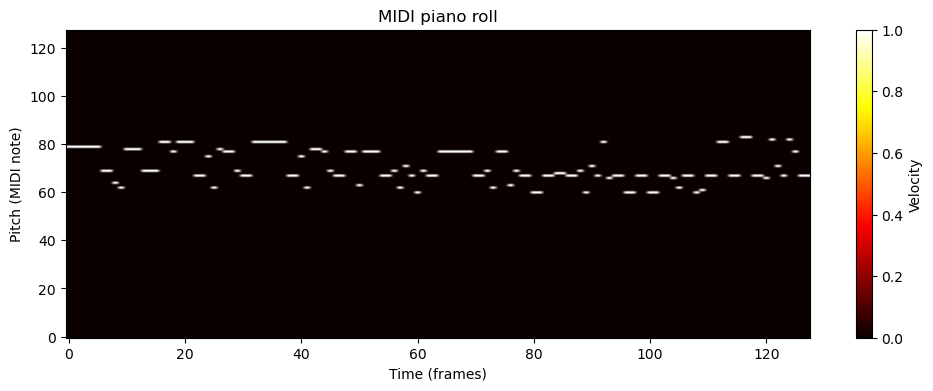

In [22]:
import random

# Define the dataset.
data_file_path = "data/preprocessed/maestro-v3.0.0/dataset2/dataset.h5"
dataset = MaestroV3DataSet(data_file_path, mode="pair")

# Random index.
rnd_idx = random.randint(0, len(dataset))

# Choose the first random sample from the dataset.
bar_0, _ = dataset[rnd_idx] # [1, 128, 16]
bar_0 = bar_0.unsqueeze(0)
print(bar_0.shape)

# Set model in evaluation.
model.eval()

# Generate noise.
noise = torch.randn(7, 1, 94)

#for z in noise:
#    print(z.shape)

# Generate 8 bar.
bars = [bar_0]
for i, z in enumerate(noise):
    # Previous bar.
    prev = bars[i-1]

    # Create the pair.
    x = z, prev

    # Generate current bar.
    curr = model(x)

    # Save genjerated bar
    bars.append(curr)
    
# Convert bars in numpy array.
bars_numpy = []
for bar in bars:
    bar = bar.squeeze(0, 1).detach().numpy()
    #print(bar.shape)
    bars_numpy.append(bar)

# Create the full piano roll.
full_piano_roll = np.hstack([bar for bar in bars_numpy])
print("Full piano roll")
print("Shape:", full_piano_roll.shape)
show_piano_roll(full_piano_roll)

# Multiply by 50.
full_piano_roll *= 50

In [23]:
# Create the output midi file.
pm = piano_roll_to_pretty_midi(full_piano_roll, fs=8)
output_fn = "output_test.midi"
pm.write(output_fn)